# Check_for_statistical_difference_in_slope.ipynb

This code uses the NDVI slope data produced from Palaeovalley_NDVI_linear_regression.py to check for statistical difference within and outside of mapped palaeovalleys. This code is based upon NDVI_wetdry_stats_plot.ipynb, but has been modified to only include one input dataset, instead of two. This code should be able to be modified for different input datasets in the future. 

Written by Claire Krause, January 2017, Datacube v 1.13, Python v3

** Code dependencies **
- csv file containing the bounding boxes for the case study site/s
- palaeovalleys 2012 shape file
- *NDVI_slope.nc from /g/ data for each of the study sites

**Accompanying code**
- Check_for_statistical_difference_in_slope_loop.ipynb - this code produces statistics for each site, and compares them in a bar chart.

In [1]:
# Import the libraries we need in the code and tell matplotlib to display the plots here
%matplotlib inline
import fiona
import shapely.geometry
import rasterio
import rasterio.features
import geopandas as gp
import datacube
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats
import pandas

In [2]:
# Set up some functions to use later in the code
def warp_geometry(geom, src_crs, dst_crs):
    """
    warp geometry from src_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(src_crs, dst_crs, shapely.geometry.mapping(geom)))

def geometry_mask(geom, geobox, all_touched=False, invert=False):
    """
    rasterize geometry into a binary mask where pixels that overlap geometry are False
    """
    return rasterio.features.geometry_mask([geom],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)

## Choose which sites we would like to statistically compare

In [3]:
# Set up the case study bounding box (to make the file smaller and avoid memory errors)
# Read in a csv file with all case study bounding boxes
names = pandas.read_csv('/g/data/p25/cek156/case_study_sites_small.csv', delimiter = ',')
print(names)

           Name     minlat     maxlat      minlon      maxlon
0   Blackwood2A -34.100000 -33.400000  116.400000  117.400000
1   Blackwood2B -34.100000 -33.400000  117.400000  118.400000
2   Blackwood2C -33.400000 -32.700000  116.400000  117.400000
3   Blackwood2D -33.400000 -32.700000  117.400000  118.400000
4      GarfordA -29.900000 -29.230000  133.150000  133.925000
5      GarfordB -29.900000 -29.230000  133.925000  134.700000
6     Mandora1A -21.100000 -20.356667  120.900000  121.916667
7     Mandora1B -21.100000 -20.356667  121.916667  122.933333
8     Mandora1C -21.100000 -20.356667  122.933333  123.950000
9     Mandora1D -21.100000 -20.356667  123.950000  124.966667
10    Mandora1E -21.100000 -20.356667  124.966667  125.983333
11    Mandora1F -21.100000 -20.356667  125.983333  127.000000
12    Mandora1G -20.356667 -19.613333  120.900000  121.916667
13    Mandora1H -20.356667 -19.613333  121.916667  122.933333
14    Mandora1I -20.356667 -19.613333  122.933333  123.950000
15    Ma

In [4]:
# Choose your site for this example
# Here we will select Blackwood2A, located in row 0
num = 0
Studysite = names.ix[num]
print(Studysite)

Name      Blackwood2A
minlat          -34.1
maxlat          -33.4
minlon          116.4
maxlon          117.4
Name: 0, dtype: object


## Set up the palaeovalley 2012 mask. 
This code reads in the shapefile and identifies and lists all of the polygons witin it. For this example, we are using the 2012 Palaeovalleys shape file (see English et al. 2012)

In [5]:
shp = gp.GeoDataFrame.from_file('/g/data/p25/cek156/Palaeovalleys_2012.shp')
print (shp.head)

<bound method NDFrame.head of                                               geometry
0    POLYGON ((123.648953793 -30.56992565499991, 12...
1    (POLYGON ((117.1778376770001 -32.2709919609999...
2    POLYGON ((115.868565061 -29.73637336599995, 11...
3    POLYGON ((115.948200584 -27.86854227199996, 11...
4    POLYGON ((127.387641593 -28.59592641999996, 12...
5    POLYGON ((128.0569520910001 -28.54635345199995...
6    POLYGON ((128.698006552 -26.21770164599991, 12...
7    POLYGON ((126.722619924 -22.32913755999994, 12...
8    POLYGON ((128.3006654730001 -18.96357787199992...
9    POLYGON ((115.3584853260001 -27.20097888599992...
10   POLYGON ((126.9556900690001 -26.30121716599996...
11   POLYGON ((115.8733712540001 -25.14138591099993...
12   POLYGON ((125.9475394960001 -28.62771558199995...
13   POLYGON ((124.9745967660001 -29.53551659999994...
14   POLYGON ((120.9398331570001 -19.64230130599992...
15   POLYGON ((128.361469574 -22.02882464999993, 12...
16   POLYGON ((123.9446491120001 -3

This section filters our polygons, to find only those that are within the bounding box we specified above. It then combines all the relevant polygons into a single polygon that we can use to create our mask.

In [6]:
# Create a bounding box from the locations specified above
box = shapely.geometry.box(names.minlon[num], names.minlat[num], names.maxlon[num], names.maxlat[num], ccw = True)
# Only get the polygons that intersect the bounding box (i.e. remove all the irrelevant ones)
filtered = shp.where(shp.intersects(box)).dropna()
# Combine all of the relevant polygons into a single polygon
shp_union = shapely.ops.unary_union(filtered.geometry)

## Read in the data we want to apply the mask to

In [7]:
slope_output_name = '/g/data/p25/cek156/NDVI/' + Studysite.Name + '/NDVI_slope.nc'
data = xr.open_dataset(slope_output_name)

In [9]:
## Hack!!
## Note that this is a temporary fix only ###

if not hasattr(data, 'geobox'):
    query = {'time': ('2000-01-01', '2000-01-31'),
             'lat': (names.maxlat[num], names.minlat[num]), 
             'lon': (names.minlon[num], names.maxlon[num]) }
    bands_of_interest = [#'blue',
                         #'green',
                         'red', 
                         #'nir',
                         #'swir1', 
                         #'swir2',
                         ]

    dc = datacube.Datacube(app='hack')
    nbar = dc.load(product = 'ls7_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
    print(nbar)

    geobox = nbar.geobox

    data.attrs['geobox'] = geobox

<xarray.Dataset>
Dimensions:  (time: 4, x: 4028, y: 3538)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-05 2000-01-12 2000-01-21 2000-01-28
  * y        (y) float64 -3.721e+06 -3.721e+06 -3.721e+06 -3.721e+06 ...
  * x        (x) float64 -1.438e+06 -1.438e+06 -1.438e+06 -1.438e+06 ...
Data variables:
    red      (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
Attributes:
    crs: EPSG:3577


In [10]:
# Create the mask based on our shapefile
mask = geometry_mask(warp_geometry(shp_union, shp.crs, data.crs), data.geobox, invert=True)
# Get data only where the mask is 'true'
data_masked = data.where(mask)
print(data_masked)

<xarray.Dataset>
Dimensions:  (x: 4028, y: 3538)
Coordinates:
  * x        (x) float64 -1.438e+06 -1.438e+06 -1.438e+06 -1.438e+06 ...
  * y        (y) float64 -3.721e+06 -3.721e+06 -3.721e+06 -3.721e+06 ...
Data variables:
    slope    (y, x) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    affine: [  2.50000000e+01   0.00000000e+00  -1.43832500e+06   0.00000000e+00
  -2.50000000e+01  -3.72080000e+06   0.00000000e+00   0.00000000e+00
   1.00000000e+00]
    crs: PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["latitude_of_center",0],PARAMETER...
    g

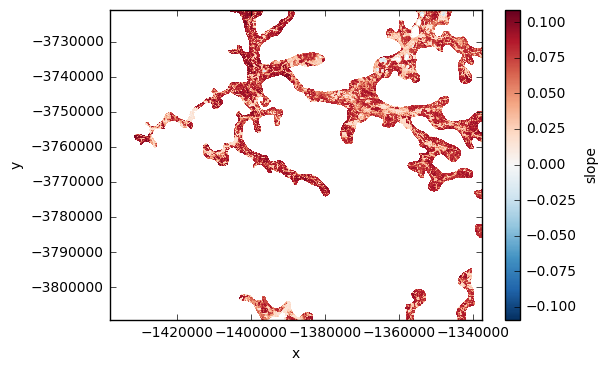

In [13]:
# Plot the masked dataset
fig = data_masked.slope.plot(cmap = 'RdBu_r')

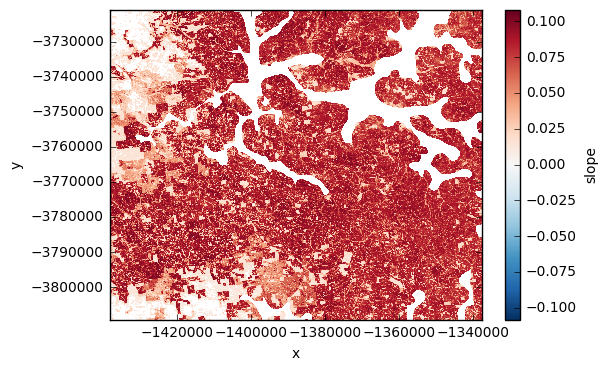

In [16]:
# Get data only where the mask is 'false'
data_maskedF = data.where(~ mask)
# Plot the opposite masked dataset
fig = data_maskedF.slope.plot()

## Now to check for statistical difference

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   3.00000000e+00,   3.00000000e+00,
          4.00000000e+00,   7.00000000e+00,   9.00000000e+00,
          1.20000000e+01,   1.40000000e+01,   2.20000000e+01,
          3.10000000e+01,   5.90000000e+01,   5.10000000e+01,
          5.90000000e+01,   4.20000000e+01,   5.60000000e+01,
          3.00000000e+01,   2.20000000e+01,   3.50000000e+01,
          3.90000000e+01,   3.40000000e+01,   4.70000000e+01,
          4.50000000e+01,   5.20000000e+01,   3.30000000e+01,
          2.40000000e+01,   1.20000000e+01,   5.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   1.60000000e+01,
          4.00000000e+01,   1.54000000e+02,   3.40000000e+02,
          6.92000000e+02,   1.46600000e+03,   2.89800000e+03,
        

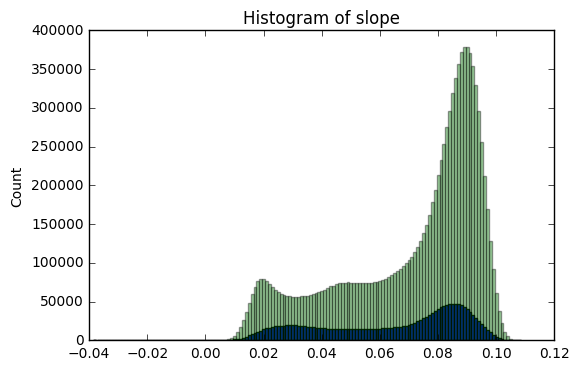

In [23]:
minval = data.slope.min()
maxval = data.slope.max()
bin_values = np.arange(start = minval, stop = maxval, step = 0.001)
data_masked.slope.plot.hist(bins = bin_values)
data_maskedF.slope.plot.hist(alpha = 0.4, bins = bin_values)

In [24]:
# Create a new numpy array with just the slope values
data_masked2 = np.array(data_masked.slope)
data_maskedF2 = np.array(data_maskedF.slope)

# Remove nan values
data_masked_nonan = data_masked2[~np.isnan(data_masked2)]
data_maskedF_nonan = data_maskedF2[~np.isnan(data_maskedF2)]
print(data_masked_nonan)
print(data_maskedF_nonan)

[ 0.09142149  0.09089205  0.08961107 ...,  0.08105325  0.08207757
  0.08268268]
[ 0.07239243  0.07112248  0.07154097 ...,  0.08575163  0.08625634
  0.08739026]


[array([ 0.09142149,  0.09089205,  0.08961107, ...,  0.08105325,
        0.08207757,  0.08268268]), array([ 0.07239243,  0.07112248,  0.07154097, ...,  0.08575163,
        0.08625634,  0.08739026])]
[1865046, 11154209]
Ttest_indResult(statistic=-368.50312387218332, pvalue=0.0)
Ks_2sampResult(statistic=0.15071826719837977, pvalue=0.0)


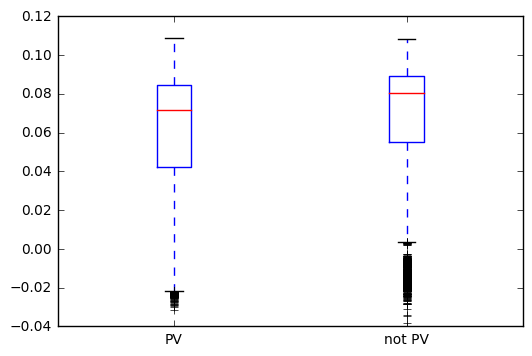

In [27]:
masked_both = [data_masked_nonan,data_maskedF_nonan]
print(masked_both)
# How many data points are in each of my NDVI lists?
size = ([len(i) for i in masked_both])
print(size)

bp = plt.boxplot(masked_both)
plt.xticks([1,2],['PV', 'not PV'])

stats_ttest = scipy.stats.ttest_ind(data_masked_nonan,data_maskedF_nonan, equal_var = 'False')
print(stats_ttest)

# Test with a Kolmogorov-Smirnov test 
# Our null hypothesis that 2 independent samples are drawn from the same continuous distribution
stats_KS = scipy.stats.ks_2samp(data_masked_nonan,data_maskedF_nonan)
print(stats_KS)